In [1]:
cd "/home/enesk/repos/spatial-prediction"

/home/enesk/repos/spatial-prediction


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
from data_set import Dataset
from predictor import Predictor, models
from predictor_utils import PiecewiseSchedule, OptimizerSpec
from utils import get_session, plot_grid, plot_confusion_matrix
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import reverb
import pandas as pd
from datetime import datetime
import random
from matplotlib import rc
import matplotlib
from active_sensing_environment import ExplorationEnvironment
from rl_env import RLEnv
import custom_py_driver
import json


import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential, q_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network
from tf_agents.trajectories import TimeStep
from tf_agents.policies import policy_saver

2023-06-08 18:30:30.841169: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print(os.environ['LD_LIBRARY_PATH'])
print(os.environ['XLA_FLAGS'])


/home/enesk/miniconda3/envs/triad4/lib/:/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorrt_libs/
--xla_gpu_cuda_data_dir=/usr/lib/cuda


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2,' # We don't need a GPU to test the model
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-06-08 18:30:32.642965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 18:30:32.647115: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 18:30:32.647307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
class TemperatureSchedule:
    def __init__(self):
        self.temp = 0.0
    def get_temp(self,):
        return self.temp

In [6]:
# Training parameters
all_params = {
"num_iterations" :  2000000, # @param {type:"integer"}
"n_step_update" :  5,
"initial_collect_steps" :  100000,  # 30000 @param {type:"integer"}
"collect_steps_per_iteration" :    1,# @param {type:"integer"}
"replay_buffer_max_length" :  4000000,  # @param {type:"integer"}
"batch_size" :  64, # @param {type:"integer"}
"learning_rate" :  1e-4,  # @param {type:"number"}
"log_interval" :  200,  # @param {type:"integer"}
"gamma" :  0.99,
"boltzmann_temperature" :  None, # temp_schedule.get_temp
"fc_layer_params" :  (512, 20),
"epsilon" :  0.1,
"model_restore_path" : None, 
#"conv_layer_params" : [(32,4,4), (64,4,4), (128,2,2)],
"conv_layer_params" : [(64,4,2), (128,4,2), (256,2,2)],
"target_update_tau" :  1,
"target_update_period" : 1000,
"num_eval_episodes" :  300,  # @param {type:"integer"}
"eval_interval" :  50000 , # @param {type:"integer"}
"single_env" :   False,
"use_sd" :  True,
"clairvoyante" :  False,
"num_atoms" : 70,  # @param {type:"integer"}
"use_categorical_dqn" : True,
"min_q_value" : 0,  # @param {type:"integer"}
"max_q_value" : 40, # @param {type:"integer"}
"use_imitation_learning" : False,
"use_pretrain_imitation_learning" : False,
"new_reward_function" : 2,
"step_size" : 4,
"random_init" : 0,
"n_agents" : 1,
"pred_session_name" : 'rand_walk_interpol',
}

for key,val in all_params.items():
    exec(key + '=val')

In [7]:
# Setup environment 
env = RLEnv(model_path=pred_session_name, single_env = single_env, use_sd=use_sd, 
                clairvoyante = clairvoyante, use_imitation_learning=use_imitation_learning,
                    step_size = step_size, new_reward_function = new_reward_function, random_init=random_init,
                        n_uavs = n_agents)



There are 660 training grids.
There are 327 testing grids.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Unet Layers Shapes:
(None, 96, 96, 2)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:loc

2023-06-08 18:32:36.233951: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 18:32:36.234189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 18:32:36.234355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(TensorShape([None, 12, 12, 128]), TensorShape([None, 6, 6, 128]))
(None, 4608)
(None, 6, 6, 128) reshape_layer_output_shape
[None, 12, 12, 128]
[None, 24, 24, 64]
[None, 48, 48, 32]
[None, 96, 96, 16]
(None, 96, 96, 1)
Unet Layers Shapes:
(None, 96, 96, 2)
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
(TensorShape([None, 48, 48, 32]), TensorShape([None, 24, 24, 32]))
(TensorShape([None, 24, 24, 64]), TensorShape([None, 12, 12, 64]))
(TensorShape([None, 12, 12, 128]), TensorShape([None, 6, 6, 128]))
(None, 4608)
(None, 6, 6, 128) reshape_layer_output_shape
[None, 12, 12, 128]
[None, 24, 24, 64]
(None, 96, 96, 1)
INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2023-06-08 18:32:39.595040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 18:32:39.595245: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-08 18:32:39.595355: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-08 18:32:39.595610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 18:32:39.595786: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-08 18:32:40.127036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 18:32:40.127257: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-08 18:32:40.127338: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-08 18:32:40.127549: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 18:32:40.127727: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2023-06-08 18:32:42.560804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 18:32:42.560999: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-08 18:32:42.561072: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-08 18:32:42.561315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 18:32:42.561497: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-08 18:32:42.849300: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 18:32:42.849520: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-08 18:32:42.849610: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-08 18:32:42.849837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 18:32:42.850012: I tensorflow/compiler/xla/stream_executor/

BoundedArraySpec(shape=(24, 24, 3), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)


In [8]:
# Storage folder
rl_session_name = datetime.now().strftime("%Y-%m-%d--%H:%M:%S")
#rl_session_name = '2023-05-13--21:30:16'
base_dir = "/home/enesk/repos/spatial-prediction/models/RL"
train_log_dir = base_dir +'/' + rl_session_name
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
train_summary_writer.set_as_default()
rl_session_name

'2023-06-08--18:32:43'

In [9]:
# Store config
config_to_store = json.dumps(all_params)
with open(train_log_dir+'/config.json', 'w') as f:
    json.dump(config_to_store, f)

In [10]:
# Convert to TF environment
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [11]:

def main():
    env.ee.policy = "random"
    env.ee.action_space.repeat_probability = 0.9
    all_rewards = []
    final_errors = []
    
    for _ in range(1):
        time_steps = train_py_env.reset()
        reward_in_episode = 0
        while not time_steps[0].is_last():
            time_steps = train_py_env.step(action=[1 for _ in time_steps])
            reward_in_episode += time_steps[0].reward
        all_rewards.append(reward_in_episode)
        final_errors.append(env.current_error)
    print("Reward per epsisode", np.mean(all_rewards))
    print("Average error", np.mean(final_errors))
    env.ee.policy = "rl"

%lprun -u 1e-3 -f train_py_env.ee.predict_ss main()


2023-06-08 18:34:18.550062: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2023-06-08 18:34:18.550171: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2023-06-08 18:34:24.026380: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1330] [TF-TRT] Sparse compute capability: enabled.


Reward per epsisode 18.907302856445312
Average error 21.092696710604127


Timer unit: 0.001 s

Total time: 86.1194 s
File: /home/enesk/repos/spatial-prediction/active_sensing_environment.py
Function: predict_ss at line 492

Line #      Hits         Time  Per Hit   % Time  Line Contents
   492                                           	def predict_ss(self, user_idx =0, no_full_covariance = False):
   493        52          1.6      0.0      0.0  		city_ob = self.building_grid
   494        52          1.3      0.0      0.0  		pwr_ob = self.ss_grids[user_idx]
   495        52          1.1      0.0      0.0  		indoor = self.building_grid > self.flying_altitude
   496                                           
   497                                           		# Get measured coords
   498        52          6.1      0.1      0.0  		measured_coords = self.get_measured_coords()
   499                                           
   500                                           		# UAV location grid for all UAVs
   501        52          1.0      0.0      0.0  		uav_

In [12]:
# Q-network 
if use_categorical_dqn:
    q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=num_atoms,
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)
else:
    print("Using standard DQN")
    q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)   


In [13]:
# DQN Agent
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0, dtype=tf.int64)

if use_categorical_dqn:
    agent = categorical_dqn_agent.CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        categorical_q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        min_q_value=min_q_value,
        debug_summaries=True,
        max_q_value=max_q_value,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)
else:
    print("Using standard DQN agent")
    agent = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        debug_summaries=True,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)

agent.initialize()

2023-06-08 18:35:44.547313: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-06-08 18:35:45.138024: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [30]:
# Define eval function
def compute_avg_return(environment, py_environment, policy, num_episodes=10):

  total_return = 0.0
  episode_errors = []

  for i in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0
    

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
    episode_errors.append(py_environment.current_error)

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0], np.mean(episode_errors), episode_errors

# New eval function
# Define eval function
def compute_avg_return(environment, policy, n_agents, num_episodes):

  total_return = 0.0
  episode_errors = []

  for i in range(num_episodes):
    # Note that there will be multiple timestep objects for multiple n_agents
    time_steps = environment.reset()
    episode_return = 0.0
    

    while not time_steps[0].is_last():
      action_steps = []
      for agent_idx in range(n_agents):
        # Create a timestep with TF values
        step_type = tf.constant(time_steps[agent_idx].step_type)
        reward = tf.constant(time_steps[agent_idx].reward)
        discount = tf.constant(time_steps[agent_idx].discount)
        observation = tf.constant([time_steps[agent_idx].observation])
        tf_ts = TimeStep( step_type, reward, discount, observation)

        # Get action
        action_step = policy.action(tf_ts)
        action_steps.append(action_step)

      # Step the environment
      time_steps = environment.step([action_step.action for action_step in action_steps])
      
      # Get reward
      episode_return += time_steps[0].reward
      
    total_return += episode_return
    episode_errors.append(environment.current_error)

  avg_return = total_return / num_episodes
  return avg_return, np.mean(episode_errors), episode_errors

In [22]:
# Eval random policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

rand_reward, rand_pred_error, errors = compute_avg_return(eval_py_env, random_policy, n_agents, num_episodes=1)

print((rand_reward, rand_pred_error))


(28.35662078857422, 11.643378829329958)


In [23]:
# Experience storage
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=n_step_update+1,
    local_server=reverb_server)

rb_observers = []
for _ in range(n_agents):
    rb_observer_i = reverb_utils.ReverbAddTrajectoryObserver(
        replay_buffer.py_client,
        table_name,     
        sequence_length=n_step_update+1)
    rb_observers.append(rb_observer_i)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpaws1nk1u.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmpaws1nk1u
[reverb/cc/platform/default/server.cc:71] Started replay server on port 34121


In [24]:


custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    rb_observers,
    use_imitation_learning = use_pretrain_imitation_learning,
    max_steps=initial_collect_steps).run(train_py_env.reset())




Traversed 9999 steps
Traversed 19999 steps
Traversed 29999 steps
Traversed 39999 steps
Traversed 49999 steps
Traversed 59999 steps
Traversed 69999 steps
Traversed 79999 steps
Traversed 89999 steps
Traversed 99999 steps


([TimeStep(
  {'discount': array(1., dtype=float32),
   'observation': array([[[0.43839   , 0.2049421 , 0.        ],
          [0.5117175 , 0.17671932, 0.        ],
          [0.52409613, 0.13507311, 0.        ],
          ...,
          [0.6302744 , 0.13651669, 0.        ],
          [0.6361884 , 0.15264219, 0.        ],
          [0.42565364, 0.2308128 , 0.        ]],
  
         [[0.594353  , 0.22401859, 0.        ],
          [0.50972533, 0.22702087, 0.        ],
          [0.46743903, 0.17500983, 0.        ],
          ...,
          [0.65337044, 0.14691785, 0.        ],
          [0.        , 0.17128459, 0.        ],
          [0.        , 0.19233312, 0.        ]],
  
         [[0.591362  , 0.18599418, 0.        ],
          [0.53651136, 0.20812893, 0.        ],
          [0.4790334 , 0.14165255, 0.        ],
          ...,
          [0.6525662 , 0.13155957, 0.        ],
          [0.        , 0.16694282, 0.        ],
          [0.        , 0.        , 0.        ]],
  
         .

In [26]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=20,
    sample_batch_size=batch_size,
    num_steps=n_step_update+1).prefetch(20)

iterator = iter(dataset)

In [41]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return, avg_error, errors = compute_avg_return(eval_py_env, agent.policy, n_agents, 2)
returns, pred_errors = [avg_return], [avg_error]
returns_collect, pred_errors_collect = [], []

# Reset the environment.
time_step = train_py_env.reset()





In [33]:
# Create a driver to collect experience.
collect_driver = custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    rb_observers,
    use_imitation_learning=use_imitation_learning,
    max_steps=collect_steps_per_iteration)

In [40]:
if model_restore_path != None:
    checkpoint_dir = os.path.join(model_restore_path, 'checkpoint')
    train_checkpointer = common.Checkpointer(
        ckpt_dir=checkpoint_dir,
        max_to_keep=1,
        agent=agent,
        policy=agent.policy,
    )
    train_checkpointer.initialize_or_restore()

checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [36]:
best_reward = np.inf
losses = []
collect_rewards = []

In [37]:
def main():
  if (use_pretrain_imitation_learning) != False:
    # Dataset generates trajectories with shape [Bx2x...]
    pretrain_dataset = replay_buffer.as_dataset(
        num_parallel_calls=20,
        sample_batch_size=batch_size,
        num_steps=n_step_update+1).prefetch(20)

    pretrain_iterator = iter(pretrain_dataset)

    for i in range(initial_collect_steps):
      # Sample a batch of data from the buffer and update the agent's network.
      step = agent.train_step_counter.numpy()
      experience, unused_info = next(pretrain_iterator)
      loss_info = agent.train(experience)
      train_loss = loss_info.loss
      losses.append(train_loss)
      rew = np.mean((experience.reward))
      collect_rewards.append(rew)
      if step % 1000 == 0:
        print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, rew*env.episode_length))
        with tf.name_scope("Training/"):
          tf.compat.v2.summary.scalar(name="Reward", data=rew*env.episode_length, step=step)
          tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
main()

In [ ]:
tf_policy_saver = policy_saver.PolicySaver(agent.policy)


In [45]:
for _ in range(1000000000):
  step = agent.train_step_counter.numpy()

  # Calculate betta for dagger
  if use_imitation_learning != False:
    start_beta = 0.999
    step_range = 4E6
    end_beta = 0.0
    beta = start_beta - (start_beta-end_beta) * step / step_range
    collect_driver._dagger_beta = beta

  

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  loss_info = agent.train(experience)
  train_loss = loss_info.loss
  losses.append(train_loss)
  rew = np.mean((experience.reward))
  collect_rewards.append(time_step[0].reward)

  

  if step % 1000 == 0:
    
    print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, np.mean(collect_rewards)*env.episode_length))
    with tf.name_scope("Training/"):
      tf.compat.v2.summary.scalar(name="Reward", data=np.mean(collect_rewards)*env.episode_length, step=step)
      tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
    collect_rewards = []

  if step % eval_interval == 0:
    avg_return, avg_error, errors = compute_avg_return(eval_py_env, agent.policy, n_agents,num_eval_episodes)
    #avg_return_collect, avg_error_collect = compute_avg_return(eval_env, eval_py_env, agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}, Average Error = {2}, Median Error = {3}'.format(step, avg_return, avg_error, np.median(errors)))
    returns.append(avg_return)
    pred_errors.append(avg_error)
    with tf.name_scope("Testing/"):
      tf.compat.v2.summary.scalar(name="Reward", data=avg_return, step=step)
      tf.compat.v2.summary.scalar(name="Error", data=avg_error, step=step)
      tf.compat.v2.summary.scalar(name="Median Error", data=np.median(errors), step=step)

    if best_reward > avg_error:
      print("Saving model")
      best_reward = avg_error
      train_checkpointer.save(step)
      tf_policy_saver.save(train_log_dir)
      avg_return, avg_error, errors = compute_avg_return(eval_py_env, agent.policy,  n_agents,num_eval_episodes)
      #avg_return_collect, avg_error_collect, errors_collect = compute_avg_return(eval_py_env, agent.collect_policy,  n_agents,num_eval_episodes)
      print('step = {0}: Average Return = {1}, Average Error = {2}, Median Error = {3}'.format(step, avg_return, avg_error, np.median(errors)))
      #print('step = {0}: Average Return 3 = {1}, Average Error 3 = {2}'.format(step, avg_return_collect, avg_error_collect))

step = 101000: loss = 3.4292244911193848,  rew = 21.55139446258545
step = 102000: loss = 3.4919567108154297,  rew = 17.271746695041656
step = 103000: loss = 3.499279022216797,  rew = 19.375652074813843
step = 104000: loss = 3.4951484203338623,  rew = 19.698959589004517
step = 105000: loss = 3.3958346843719482,  rew = 22.46232032775879
step = 106000: loss = 3.5185141563415527,  rew = 21.61925435066223
step = 107000: loss = 3.4695138931274414,  rew = 23.017622530460358
step = 108000: loss = 3.4626500606536865,  rew = 22.35284447669983
step = 109000: loss = 3.4588406085968018,  rew = 19.364504516124725
step = 110000: loss = 3.5037245750427246,  rew = 22.505618631839752
step = 111000: loss = 3.5080790519714355,  rew = 20.71055769920349
step = 112000: loss = 3.5149965286254883,  rew = 20.82434892654419
step = 113000: loss = 3.4315428733825684,  rew = 21.593643724918365
step = 114000: loss = 3.476512908935547,  rew = 21.120594441890717
step = 115000: loss = 3.411329746246338,  rew = 17.34530

step = 350000: Average Return = 21.45852688829104, Average Error = 18.802423210072973
Saving model


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--18:32:43/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--18:32:43/assets


step = 350000: Average Return 2 = 21.269908009171488, Average Error 2 = 19.00992456721861
step = 351000: loss = 3.2758007049560547,  rew = 18.681007623672485
step = 352000: loss = 3.2867884635925293,  rew = 20.71451097726822
step = 353000: loss = 3.189708948135376,  rew = 21.540741622447968
step = 354000: loss = 3.3132376670837402,  rew = 20.71933001279831
step = 355000: loss = 3.253720283508301,  rew = 25.153884291648865
step = 356000: loss = 3.3163135051727295,  rew = 20.54063081741333
step = 357000: loss = 3.298748016357422,  rew = 20.91936320066452
step = 358000: loss = 3.3683464527130127,  rew = 19.90758925676346
step = 359000: loss = 3.275519609451294,  rew = 19.11110430955887
step = 360000: loss = 3.169306993484497,  rew = 19.395434856414795
step = 361000: loss = 3.4315712451934814,  rew = 21.178020536899567
step = 362000: loss = 3.361431121826172,  rew = 21.62182629108429
step = 363000: loss = 3.2774856090545654,  rew = 16.896627843379974
step = 364000: loss = 3.312225103378296

step = 400000: Average Return = 22.102748467127483, Average Error = 18.303322316612523
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--18:32:43/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--18:32:43/assets


step = 400000: Average Return 2 = 21.776637625694274, Average Error 2 = 18.666243148001815
step = 401000: loss = 3.3040239810943604,  rew = 21.549007296562195
step = 402000: loss = 3.2537331581115723,  rew = 20.853738486766815
step = 403000: loss = 3.288931369781494,  rew = 22.506169974803925
step = 404000: loss = 3.3474888801574707,  rew = 21.795767545700073
step = 405000: loss = 3.2792911529541016,  rew = 21.98084443807602
step = 406000: loss = 3.31036639213562,  rew = 19.43143606185913
step = 407000: loss = 3.279489517211914,  rew = 20.648208260536194
step = 408000: loss = 3.279953956604004,  rew = 21.449637413024902
step = 409000: loss = 3.2017135620117188,  rew = 23.63462597131729
step = 410000: loss = 3.401442527770996,  rew = 20.41894793510437
step = 411000: loss = 3.1918952465057373,  rew = 22.881796956062317
step = 412000: loss = 3.2512454986572266,  rew = 22.558017075061798
step = 413000: loss = 3.4502062797546387,  rew = 18.82784366607666
step = 414000: loss = 3.299576044082

step = 450000: Average Return = 22.006264691750207, Average Error = 18.101548932047432
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--18:32:43/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--18:32:43/assets


step = 450000: Average Return 2 = 21.2373385711511, Average Error 2 = 19.490872578008677
step = 451000: loss = 3.229588031768799,  rew = 18.101973831653595
step = 452000: loss = 3.2889630794525146,  rew = 21.667037904262543
step = 453000: loss = 3.20413875579834,  rew = 21.16999924182892
step = 454000: loss = 3.321014881134033,  rew = 24.92009848356247
step = 455000: loss = 3.3314473628997803,  rew = 23.705759644508362
step = 456000: loss = 3.3228726387023926,  rew = 22.59548008441925
step = 457000: loss = 3.270606279373169,  rew = 24.68939870595932
step = 458000: loss = 3.3059983253479004,  rew = 17.509031295776367
step = 459000: loss = 3.2849788665771484,  rew = 23.64085018634796
step = 460000: loss = 3.3372795581817627,  rew = 22.0685213804245
step = 461000: loss = 3.307326555252075,  rew = 19.395719468593597
step = 462000: loss = 3.216862678527832,  rew = 19.002273678779602
step = 463000: loss = 3.2634024620056152,  rew = 19.318343698978424
step = 464000: loss = 3.3501136302948,  r

step = 500000: Average Return = 22.340868746787308, Average Error = 17.858741326608087
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--18:32:43/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--18:32:43/assets


step = 500000: Average Return 2 = 22.466456554929415, Average Error 2 = 17.68578079098705
step = 501000: loss = 3.295609951019287,  rew = 21.236181259155273
step = 502000: loss = 3.266763687133789,  rew = 21.43227905035019
step = 503000: loss = 3.2706706523895264,  rew = 19.685503840446472
step = 504000: loss = 3.3012290000915527,  rew = 21.0170716047287
step = 505000: loss = 3.2162160873413086,  rew = 21.517914533615112
step = 506000: loss = 3.1390819549560547,  rew = 19.47840303182602
step = 507000: loss = 3.2455270290374756,  rew = 24.5526522397995
step = 508000: loss = 3.2175731658935547,  rew = 19.596265256404877
step = 509000: loss = 3.133845806121826,  rew = 23.420624434947968
step = 510000: loss = 3.3395237922668457,  rew = 19.92531716823578
step = 511000: loss = 3.242018222808838,  rew = 17.78661012649536
step = 512000: loss = 3.155674457550049,  rew = 19.711443781852722
step = 513000: loss = 3.3244147300720215,  rew = 20.955581963062286
step = 514000: loss = 3.253392457962036

step = 650000: Average Return = 22.314443790713945, Average Error = 17.795557255942217
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--18:32:43/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--18:32:43/assets


step = 650000: Average Return 2 = 21.44605406264464, Average Error 2 = 18.91026108210815
step = 651000: loss = 3.264374256134033,  rew = 20.71641981601715
step = 652000: loss = 3.1791865825653076,  rew = 23.97918701171875
step = 653000: loss = 3.3085732460021973,  rew = 21.473003923892975
step = 654000: loss = 3.253242015838623,  rew = 22.980082035064697
step = 655000: loss = 3.269106388092041,  rew = 19.90141123533249
step = 656000: loss = 3.1862564086914062,  rew = 19.664141535758972
step = 657000: loss = 3.4243786334991455,  rew = 22.30251282453537
step = 658000: loss = 3.099490165710449,  rew = 22.130703926086426
step = 659000: loss = 3.331723690032959,  rew = 23.05142879486084
step = 660000: loss = 3.220705986022949,  rew = 22.626329958438873
step = 661000: loss = 3.2365498542785645,  rew = 18.830202519893646
step = 662000: loss = 3.2824039459228516,  rew = 23.667171597480774
step = 663000: loss = 3.3399291038513184,  rew = 21.860265731811523
step = 664000: loss = 3.26921224594116

step = 900000: Average Return = 22.779408331712087, Average Error = 17.43618062767939
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--18:32:43/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--18:32:43/assets


step = 900000: Average Return 2 = 21.912171651124954, Average Error 2 = 18.464815525543873
step = 901000: loss = 3.3611559867858887,  rew = 20.673154294490814
step = 902000: loss = 3.2910029888153076,  rew = 22.204554080963135
step = 903000: loss = 3.297727108001709,  rew = 22.858044505119324
step = 904000: loss = 3.308229923248291,  rew = 20.20830065011978
step = 905000: loss = 3.300961494445801,  rew = 23.074965178966522
step = 906000: loss = 3.3804662227630615,  rew = 17.96141117811203
step = 907000: loss = 3.3391575813293457,  rew = 23.393407464027405
step = 908000: loss = 3.3129611015319824,  rew = 16.87384992837906
step = 909000: loss = 3.2525219917297363,  rew = 20.949581265449524
step = 910000: loss = 3.302485942840576,  rew = 24.25215244293213
step = 911000: loss = 3.3104248046875,  rew = 20.042023062705994
step = 912000: loss = 3.2289576530456543,  rew = 23.75202476978302
step = 913000: loss = 3.2292256355285645,  rew = 19.308722019195557
step = 914000: loss = 3.2900011539459

step = 1200000: Average Return = 22.949652802149455, Average Error = 17.236896045774092
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--18:32:43/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--18:32:43/assets


step = 1200000: Average Return 2 = 22.180354328627388, Average Error 2 = 18.261276910238674
step = 1201000: loss = 3.203174114227295,  rew = 22.279542684555054
step = 1202000: loss = 3.275399923324585,  rew = 22.684702277183533
step = 1203000: loss = 3.3519957065582275,  rew = 19.012990593910217
step = 1204000: loss = 3.2583556175231934,  rew = 19.358423352241516
step = 1205000: loss = 3.322094678878784,  rew = 22.57331758737564
step = 1206000: loss = 3.35880184173584,  rew = 22.66789972782135
step = 1207000: loss = 3.3905322551727295,  rew = 24.44688081741333
step = 1208000: loss = 3.3105692863464355,  rew = 21.024425327777863
step = 1209000: loss = 3.329131603240967,  rew = 20.291469991207123
step = 1210000: loss = 3.310091972351074,  rew = 22.874295711517334
step = 1211000: loss = 3.1910626888275146,  rew = 22.373010218143463
step = 1212000: loss = 3.2412476539611816,  rew = 20.411600172519684
step = 1213000: loss = 3.2986865043640137,  rew = 21.27082049846649
step = 1214000: loss =

In [34]:
# Update the epsilon
agent.collect_policy._epsilon = 0.01

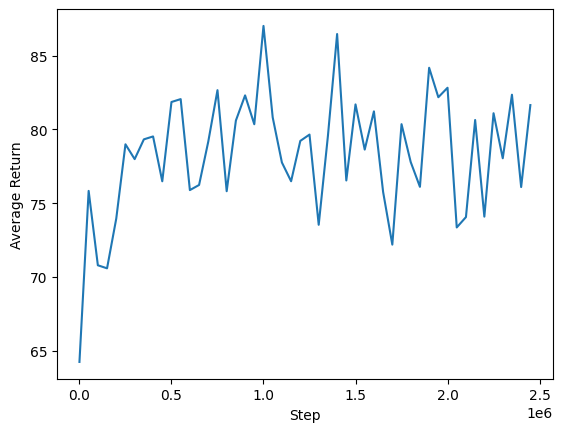

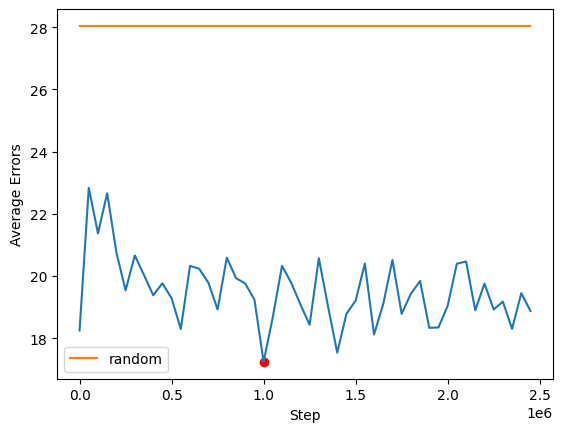

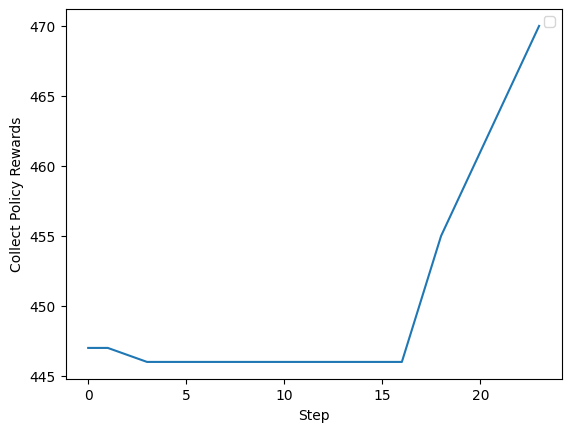

ValueError: setting an array element with a sequence.

In [ ]:
%matplotlib inline
steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, pred_errors)
plt.plot(steps, np.ones(len(pred_errors))*rand_pred_error, label = "random")
plt.scatter([steps[np.argmin(pred_errors)]], [np.min(pred_errors)], c = 'r')
plt.ylabel('Average Errors')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(collect_rewards, np.ones(40)*200/40, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

In [38]:
# Evaluate model again
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 500)
print(avg_return, avg_error)

scenario (2, 6)
scenario (8, 15)
scenario (15, 7)
scenario (9, 16)
scenario (6, 4)
scenario (15, 18)
scenario (12, 19)
scenario (8, 10)
scenario (14, 6)
scenario (2, 10)
scenario (14, 13)
scenario (1, 6)
scenario (12, 6)
scenario (12, 11)
scenario (7, 0)
scenario (8, 2)
scenario (5, 22)
scenario (14, 17)
scenario (2, 1)
scenario (7, 3)
scenario (6, 19)
scenario (1, 1)
scenario (7, 15)
scenario (5, 13)
scenario (4, 11)
scenario (3, 19)
scenario (11, 1)
scenario (2, 8)
scenario (3, 21)
scenario (12, 15)
scenario (5, 9)
scenario (4, 11)
scenario (7, 19)
scenario (3, 5)
scenario (10, 10)
scenario (3, 1)
scenario (8, 12)
scenario (11, 12)
scenario (10, 16)
scenario (6, 0)
scenario (12, 12)
scenario (1, 9)
scenario (7, 2)
scenario (8, 3)
scenario (11, 11)
scenario (10, 15)
scenario (15, 18)
scenario (15, 2)
scenario (1, 18)
scenario (11, 4)
scenario (7, 14)
scenario (9, 5)
scenario (9, 2)
scenario (2, 11)
scenario (13, 5)
scenario (9, 2)
scenario (11, 10)
scenario (15, 16)
scenario (6, 18)
s

In [39]:
# Restore best model
checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [44]:
# Evaluate model again
avg_return, avg_error, all_errors = compute_avg_return(eval_env, eval_py_env, agent.policy, 500)
print(avg_return, avg_error, np.median(all_errors))

21.389935 18.875355349545128 16.891530539265013


In [46]:
saved_policy = tf.saved_model.load(train_log_dir)
avg_return, avg_error, all_errors = compute_avg_return(eval_env, eval_py_env, saved_policy, 500)
print(avg_return, avg_error, np.median(all_errors))

22.180067 18.042663407910684 15.942696826344214


In [48]:
for _ in range(10 ):
    avg_return, avg_error, errors = compute_avg_return(eval_env, eval_py_env, agent.collect_policy, 300)
    print(avg_return, avg_error, np.median(errors))
    avg_return, avg_error, errors = compute_avg_return(eval_env, eval_py_env, agent.policy, 300)
    print(avg_return, avg_error, np.median(errors))
    avg_return, avg_error, errors = compute_avg_return(eval_env, eval_py_env, saved_policy, 300)
    print(avg_return, avg_error, np.median(errors))
    print("-----")

21.274477 19.220210118026124 16.71720350098706
21.992966 18.17329818730034 16.322821892611802
22.40089 17.783620134237342 15.56030104543466
-----
21.962563 18.508083564747626 15.796726738584216
22.278505 17.97026463940224 16.142361714999854
22.925522 17.205344615955145 15.376846986288108
-----
21.655895 18.916020020841163 16.07169769223762
21.694723 18.748819106149742 15.945960191149876
22.871656 17.304316534342234 15.386934830599262
-----
22.687538 17.549744496306552 15.626071511583362
20.815147 19.773261721583058 17.248981115757072
23.182003 16.824780999871923 15.450890097210854
-----
22.464167 17.81198178100019 15.727207250718898
21.914091 18.52578815275641 15.835416148176286
22.639826 17.5665066158895 15.806813087408031
-----
21.70445 18.642621200840136 16.51116737163632
21.514198 19.018445888650547 16.125080307541644
22.944416 17.165800491065546 15.369511310088935
-----
21.246733 19.03743958263471 17.148065586755386
21.423414 18.821447123081406 16.912032517272166
22.931805 17.1707